# Introduction

時系列データの異常検知を行います。

今回は深層学習による異常検知を行います。


# 各種ライブラリの取得



In [1]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
plt.style.use('ggplot')

/Users/masayaohgushi/.virtualenvs/time_series_anomaly_detect/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [2]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

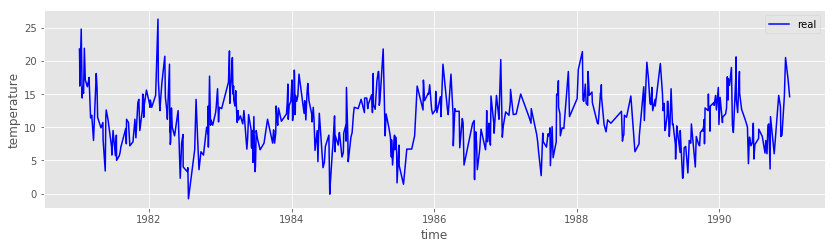

In [3]:
X_orig = wave_data["Temp"].values
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

# データの分割

- 学習データ
- 検証データ
- テストデータ

In [4]:
print(X_orig.shape)

X_train = X_orig[:300]
X_valid = X_orig[300:400]
X_test = X_orig[400:]
X_train_day = X_day[:300]
X_valid_day = X_day[300:400]
X_test_day = X_day[400:]

(500,)


# 学習データ

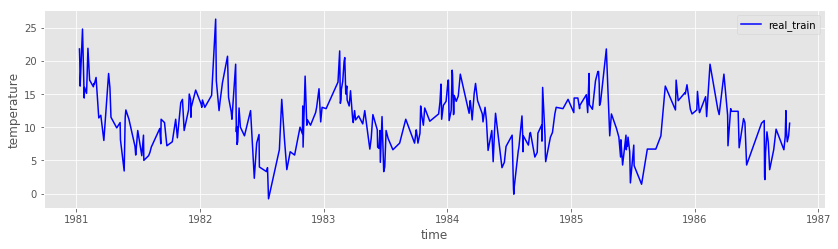

In [5]:
show_graph(X_train_day, X_train, 'real_train')

# 検証データ

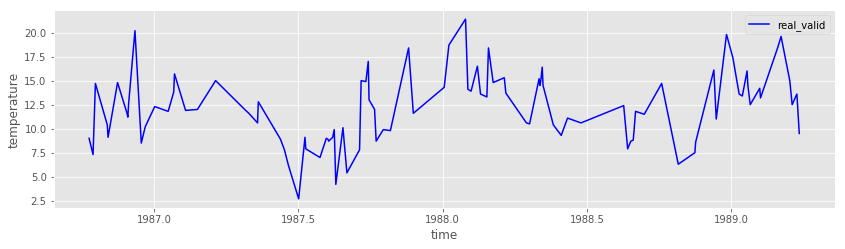

In [6]:
show_graph(X_valid_day, X_valid, 'real_valid')

# テストデータ

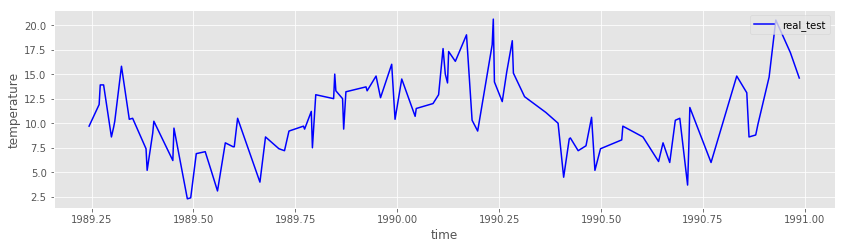

In [7]:
show_graph(X_test_day, X_test, 'real_test')

# 前処理

- `get_data`: データを前処理して深層学習で扱える形に変換する
- `transform_data`: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [43]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    for i in range(len(data) - time_steps - 1):
        x = data[i:(i + time_steps), :]
        dataX.append(x)
    return np.array(dataX)

def transform_data(original_data: np.array, inverse_option: bool, scaler: object):
    data_shape = original_data.shape
    data = original_data.reshape(-1, 1)
    if inverse_option is True:
        print('before max {}'.format(max(data)))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data)))
    else:
        print('before max {}'.format(max(data)))
        print('Normalize')
        data = scaler.fit_transform(data)
        print(max(data))
        print('after max {}'.format(max(data)))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler)
    data = np.asarray(data)
    data = data.reshape(-1, 1)
    x = get_data(data, time_steps=time_steps)
    return x, scaler

time_steps = 3

x, scaler = prepare_data(X_train, time_steps)

input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)

before max [26.3]
Normalize
[1.]
after max [1.]
(300, 1)
(296, 3, 1)


# モデルの作成

- `create_model`でモデルを作成しています。指定できるのは
   - timestepsの幅
   - ノードの数
   - 自身の状態をリセットするかしないかを指定する`stateful`(周期的な波形は`True`の方が若干良くなります。)
   - `model_option`でGRUもしくはLSTMを選択できます。
   - `optimizer`で設定したい`optimizer`を指定できます。デファオルトでは`adam`が入っています。

In [29]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 # データが一つしかないので1しか選べない
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam'
                ):
    x = Input(shape=(time_steps, input_dim,))

    if model_option == 'lstm':
        h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
    elif model_option == 'gru':
        h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

    out = Dense(input_dim)(h)

    model = Model(x, out)
    model.summary()

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

model = create_model(input_dim, 
                     time_steps=time_steps,
                     latent_dim=120,
                     model_option='lstm')
model.fit(x, x, epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 120)            58560     
_________________________________________________________________
dense_2 (Dense)              (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
296/296 [==============================] - 1s 2ms/step - loss: 0.1824 - mean_squared_error: 0.1824
Epoch 2/200
296/296 [==============================] - 0s 145us/step - loss: 0.0979 - mean_squared_error: 0.0979
Epoch 3/200
296/296 [==============================] - 0s 150us/step - loss: 0.0550 - mean_squared_error: 0.0550
Epoch 4/200
296/296 [==============================] - 0s 148us/s

296/296 [==============================] - 0s 202us/step - loss: 2.3455e-04 - mean_squared_error: 2.3455e-04
Epoch 66/200
296/296 [==============================] - 0s 187us/step - loss: 2.2710e-04 - mean_squared_error: 2.2710e-04
Epoch 67/200
296/296 [==============================] - 0s 199us/step - loss: 2.1941e-04 - mean_squared_error: 2.1941e-04
Epoch 68/200
296/296 [==============================] - 0s 287us/step - loss: 2.1210e-04 - mean_squared_error: 2.1210e-04
Epoch 69/200
296/296 [==============================] - 0s 302us/step - loss: 2.0407e-04 - mean_squared_error: 2.0407e-04
Epoch 70/200
296/296 [==============================] - 0s 241us/step - loss: 2.0779e-04 - mean_squared_error: 2.0779e-04
Epoch 71/200
296/296 [==============================] - 0s 232us/step - loss: 1.9265e-04 - mean_squared_error: 1.9265e-04
Epoch 72/200
296/296 [==============================] - 0s 271us/step - loss: 1.8943e-04 - mean_squared_error: 1.8943e-04
Epoch 73/200
296/296 [===============

Epoch 132/200
296/296 [==============================] - 0s 153us/step - loss: 3.5518e-05 - mean_squared_error: 3.5518e-05
Epoch 133/200
296/296 [==============================] - 0s 151us/step - loss: 3.5039e-05 - mean_squared_error: 3.5039e-05
Epoch 134/200
296/296 [==============================] - 0s 153us/step - loss: 3.3891e-05 - mean_squared_error: 3.3891e-05
Epoch 135/200
296/296 [==============================] - 0s 151us/step - loss: 3.3254e-05 - mean_squared_error: 3.3254e-05
Epoch 136/200
296/296 [==============================] - 0s 145us/step - loss: 3.1925e-05 - mean_squared_error: 3.1925e-05
Epoch 137/200
296/296 [==============================] - 0s 148us/step - loss: 3.1304e-05 - mean_squared_error: 3.1304e-05
Epoch 138/200
296/296 [==============================] - 0s 150us/step - loss: 3.1705e-05 - mean_squared_error: 3.1705e-05
Epoch 139/200
296/296 [==============================] - 0s 156us/step - loss: 3.0010e-05 - mean_squared_error: 3.0010e-05
Epoch 140/200
29

296/296 [==============================] - 0s 162us/step - loss: 1.2467e-05 - mean_squared_error: 1.2467e-05
Epoch 199/200
296/296 [==============================] - 0s 153us/step - loss: 1.2185e-05 - mean_squared_error: 1.2185e-05
Epoch 200/200
296/296 [==============================] - 0s 152us/step - loss: 1.2224e-05 - mean_squared_error: 1.2224e-05


# モデルの学習と学習データの予測

before max [26.3]
Normalize
[1.]
after max [1.]
(300, 1)
before max [1.]
Inverse
after max [26.3]
before max [1.0230602]
Inverse
after max [26.924932]


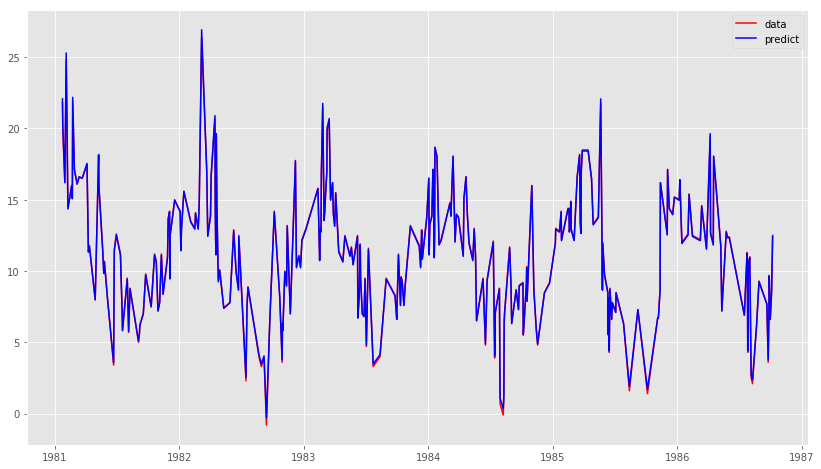

In [30]:
def predict_model_show_graph(day, x, scaler):
    prepare_value = x.copy()
    preds = model.predict(prepare_value)

    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, scaler=scaler)
    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, scaler=scaler)
    
    plt.figure(figsize=(14, 8))
    plt.plot(day, x_scale[:, 0, 0], color='r', label='data')
    plt.plot(day, predict_scale[:, 0, 0], color='b', label='predict')
    plt.legend()
    plt.show()
    return predict_scale, x_scale

window = time_steps
x_predict, scaler = prepare_data(X_train, time_steps)
predict_train, x_scale_train = predict_model_show_graph(X_train_day[window + 1:], x_predict, scaler)

# 検証データに対する予測

before max [21.4]
Normalize
[1.]
after max [1.]
(100, 1)
before max [1.]
Inverse
after max [21.4]
before max [1.0230602]
Inverse
after max [21.831224]


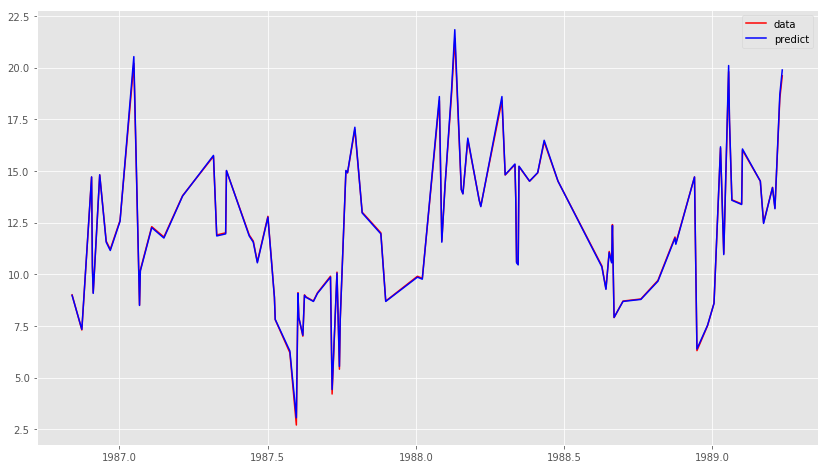

In [31]:
x_valid, scaler_valid = prepare_data(X_valid, time_steps)

predict_valid, x_scale_valid = predict_model_show_graph(X_valid_day[window + 1:], x_valid, scaler_valid)

# 異常データの作成

本来は元データに異常を付与する必要があるが分かりづらいのでスムージングしたデータに異常を付与

- スパイク型
- 波形変化
- レベルシフト

# スパイク型

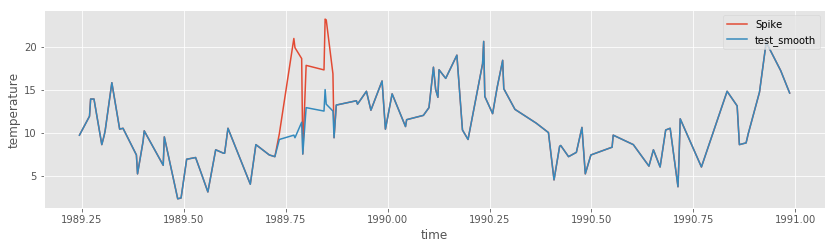

In [15]:
def show_2data_graph(day, data, compare_data, label, compare_label):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, label=label)
    pylab.plot(day, compare_data, label=compare_label)
    pylab.legend(loc='upper right')
    pylab.show()

series = [np.abs(gauss(0.0, 10.0)) for i in range(10)]
spike_X = X_test.copy() 
spike_X[30:40] = spike_X[30:40] + series

show_2data_graph(X_test_day, spike_X, X_test, 'Spike', 'test_smooth')

# 波形変化

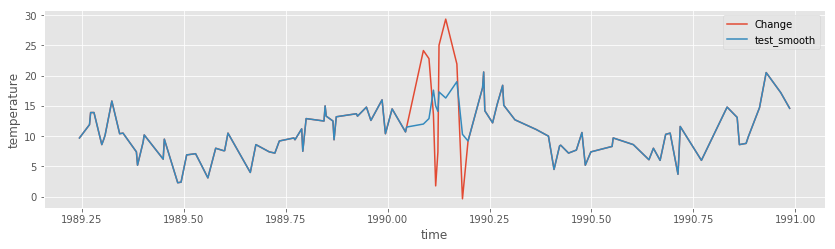

In [16]:
change_value = np.arange(0, 200, 20)
change_X = X_test.copy() 
# change_X[60:70] = change_X[60:70] - (0.2 * change_X[60:70] * np.sin(change_value))

change_X[50:60] = change_X[50:60] + (0.7 * np.max(change_X[50:60]) * (np.sin(change_value)))

show_2data_graph(X_test_day, change_X, X_test, 'Change', 'test_smooth')

# レベルシフト

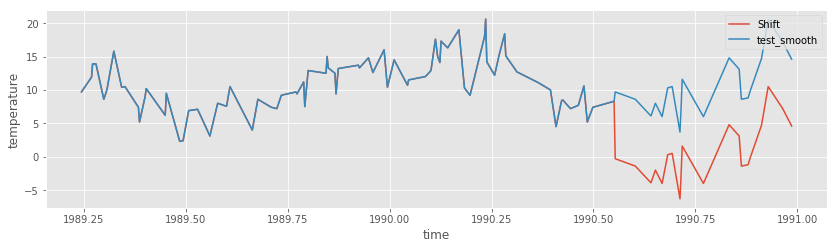

In [17]:
shift_X = X_test.copy() 
shift_X[80:] = shift_X[80:] - 10.0

show_2data_graph(X_test_day, shift_X, X_test, 'Shift', 'test_smooth')

#  Anomaly Score

異常度の計算部分
- 初回の計算は分散が不定なので1で固定
- 学習データで導出した分散を使用
- windowのズレが予測時に生じる

before max [26.924932]
Normalize
[1.]
after max [1.]


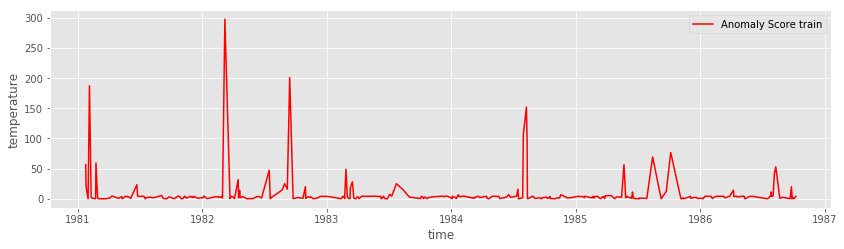

In [32]:
def smooth(x, window_len=11):

    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), x, mode='valid')
    return y

def calculate_mse(value, predict_value, variance=1.0):
    value = value[:, 0, 0]
    predict_value = predict_value[:, 0, 0]
    # value = smooth(value)
    # predict_value = smooth(predict_value)
    mse_value = [(v - p_v)**2 / variance for v, p_v in zip(value, predict_value)]
    return np.array(mse_value)

window = timesteps

# mse_value_org = calculate_mse(x_scale_train, predict_train)

def normalize_predict(predict):
    copy_predict = predict.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    copy_predict, scaler = transform_data(original_data=copy_predict, inverse_option=False, scaler=scaler)
    return copy_predict

normalize_predict_train = normalize_predict(predict_train)

# mse_value_org = calculate_mse(x, normalize_predict_train)
mse_value_org = calculate_mse(x_scale_train, predict_train)

mse_value_variance = np.var(mse_value_org)
# mse_value_variance = 1.0

mse_value = calculate_mse(x, normalize_predict_train, mse_value_variance)
mse_value = calculate_mse(x_scale_train, predict_train, mse_value_variance)

show_graph(X_train_day[window + 1:], mse_value, 'Anomaly Score train', color="r")

# 検証データの異常度

実運用では異常データは存在しないと過程して検証データのみで閾値を設定

before max [21.831224]
Normalize
[1.]
after max [1.]


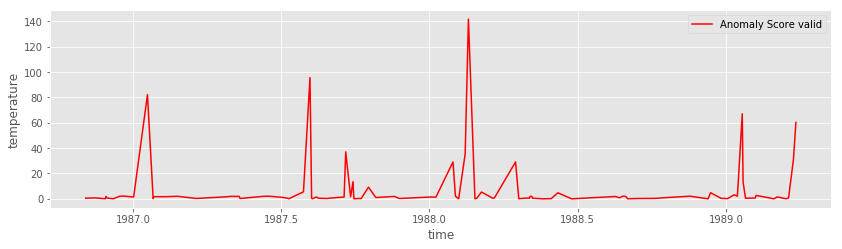

threshold value 141.75150955966996


In [33]:
normalize_predict_valid = normalize_predict(predict_valid)

# mse_value_valid = calculate_mse(x_valid, normalize_predict_valid, mse_value_variance)

mse_value_valid = calculate_mse(x_scale_valid, predict_valid, mse_value_variance)

show_graph(X_valid_day[window + 1:], mse_value_valid, 'Anomaly Score valid', color="r")

threshold = np.max(mse_value_valid)
print("threshold value {}".format(threshold))
total_mse = np.append(mse_value, mse_value_valid)
threshold_variance = np.std(total_mse)
threshold_mean = np.mean(total_mse)
# 
# threshold = 2 * threshold_variance + threshold_mean
# print("threshold value {}".format(threshold))

# Anomaly Detection

# Normal Data Case

正常データは異常として検知しないかを確認

before max [20.6]
Normalize
[1.]
after max [1.]
(100, 1)
before max [1.]
Inverse
after max [20.6]
before max [1.0230602]
Inverse
after max [21.022001]


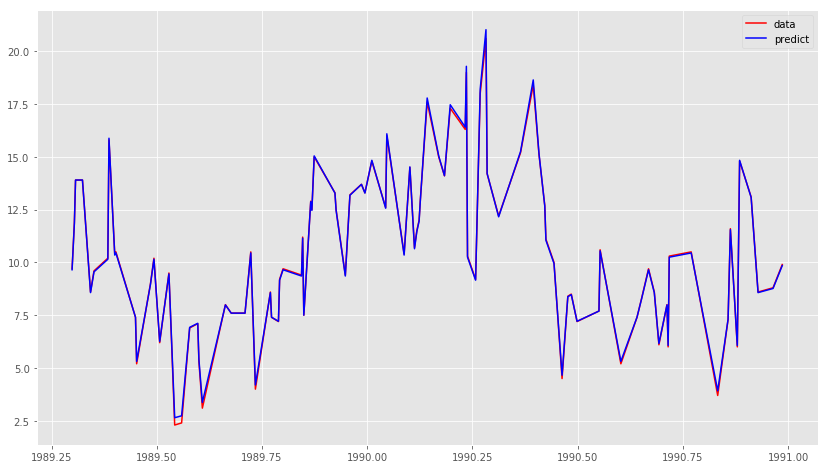

before max [21.022001]
Normalize
[1.]
after max [1.]


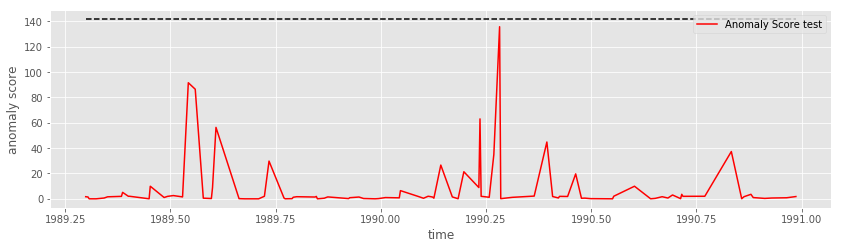

In [34]:
def show_graph_threshold(day, data, threshold, label, color="b", fix_threshold=True):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('anomaly score')
    if fix_threshold is True:
        pylab.plot(day, np.repeat(threshold, day.shape[0]), 'k-', color = "k", ls = "dashed")
    else:
        pylab.plot(day, threshold, 'k-', color = "k", ls = "dashed")
    pylab.plot(day, data, "r", label='Anomaly Score test')
    pylab.legend(loc='upper right')
    pylab.show()

x_test, scaler_test = prepare_data(X_test, time_steps)

predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], x_test, scaler_test)

normalize_predict_test= normalize_predict(predict_test)

# mse_value_test_normal = calculate_mse(x_test, normalize_predict_test, mse_value_variance)
mse_value_test_normal = calculate_mse(x_scale_test, predict_test, mse_value_variance)


time_threshold = mse_value_test_normal + threshold_variance + threshold_mean
show_graph_threshold(X_test_day[window + 1:], mse_value_test_normal, threshold, 'Anomaly Score test', "r")
# show_graph_threshold(X_test_day[window + 1:], mse_value_test_normal, time_threshold, 'Anomaly Score test', "r")

# Spike Wave Case

before max [23.19078151]
Normalize
[1.]
after max [1.]
(100, 1)
before max [1.]
Inverse
after max [23.19078151]
before max [1.0230602]
Inverse
after max [23.672527]


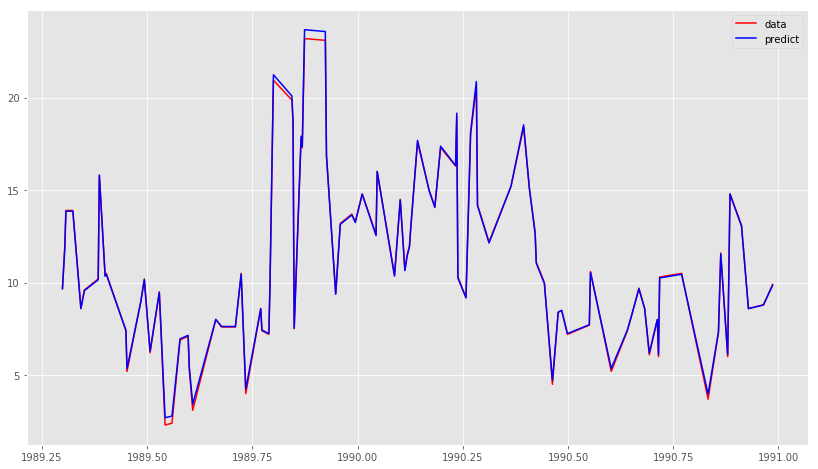

before max [23.672527]
Normalize
[1.]
after max [1.]


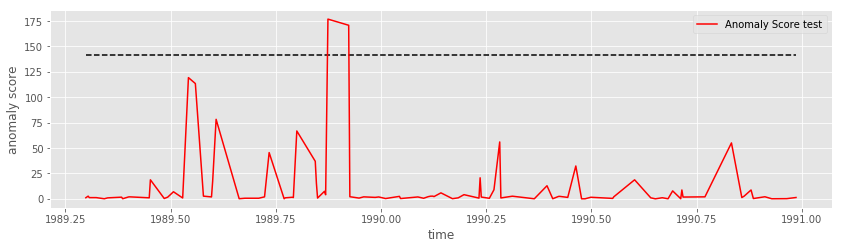

In [35]:
anomaly_spike = spike_X.copy()

anomaly_spike, scaler_test_spike = prepare_data(anomaly_spike, time_steps)

predict_test, anomaly_spike_scale = predict_model_show_graph(X_test_day[window + 1:], anomaly_spike, scaler_test_spike)

normalize_predict_test = normalize_predict(predict_test)

# mse_value_test_spike = calculate_mse(anomaly_spike, normalize_predict_test, mse_value_variance)
mse_value_test_spike = calculate_mse(anomaly_spike_scale, predict_test, mse_value_variance)

show_graph_threshold(X_test_day[window + 1:], mse_value_test_spike, threshold, 'Anomaly Score test Spike', "r")

# Change Wave Case

before max [29.33718747]
Normalize
[1.]
after max [1.]
(100, 1)
before max [1.]
Inverse
after max [29.33718747]
before max [1.0230602]
Inverse
after max [30.021904]


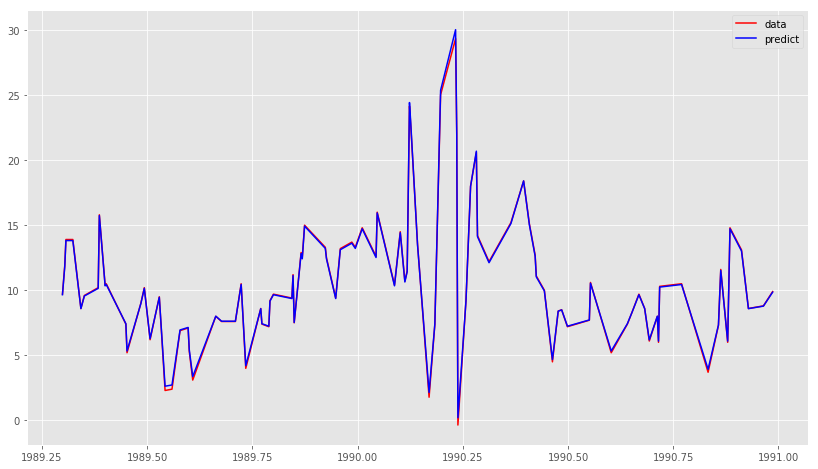

before max [30.021904]
Normalize
[1.0000001]
after max [1.0000001]


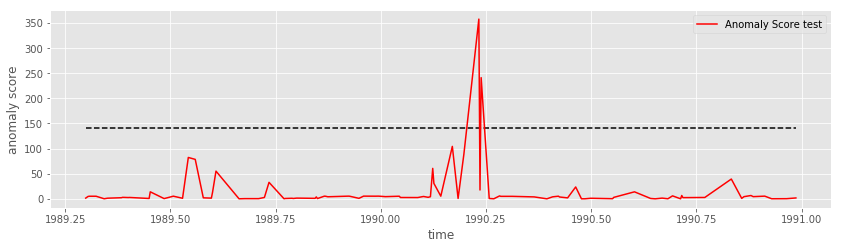

In [36]:
anomaly_change = change_X.copy()
anomaly_change, scaler_test_change = prepare_data(anomaly_change, time_steps)

predict_test, anomaly_change_scale = predict_model_show_graph(X_test_day[window + 1:], anomaly_change, scaler_test_change)

normalize_predict_test = normalize_predict(predict_test)

# mse_value_test_change = calculate_mse(anomaly_change, normalize_predict_test, mse_value_variance)
mse_value_test_change = calculate_mse(anomaly_change_scale, predict_test, mse_value_variance)

show_graph_threshold(X_test_day[window + 1:], mse_value_test_change, threshold, 'Anomaly Score test Change', "r")

# Shift Wave Case

before max [20.6]
Normalize
[1.]
after max [1.]
(100, 1)
before max [1.]
Inverse
after max [20.6]
before max [1.0230602]
Inverse
after max [21.22032]


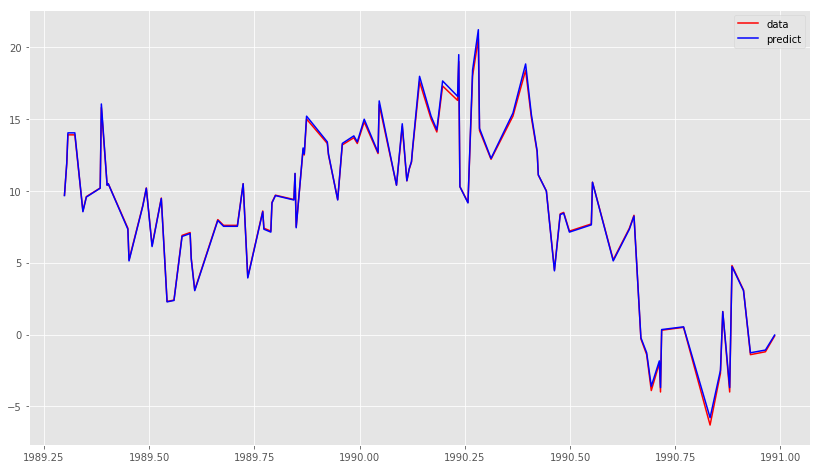

before max [21.22032]
Normalize
[1.]
after max [1.]


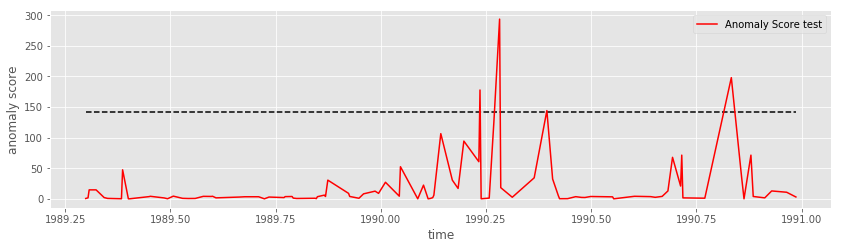

In [37]:
anomaly_shift = shift_X.copy()
anomaly_shift, scaler_test_shift = prepare_data(anomaly_shift, time_steps)

predict_test, anomaly_shift_scale = predict_model_show_graph(X_test_day[window + 1:], anomaly_shift, scaler_test_shift)

normalize_predict_test = normalize_predict(predict_test)

mse_value_test_shift = calculate_mse(anomaly_shift_scale, predict_test, mse_value_variance)
# mse_value_test_shift = calculate_mse(anomaly_shift, normalize_predict_test, mse_value_variance)

show_graph_threshold(X_test_day[window + 1:], mse_value_test_shift, threshold, 'Anomaly Score test Shift', "r")

# 正常データと異常データの分布

(96,)
(36,)
mean 8.138748838907151
mean anomaly 52.9536533389797
std 21.090066882418295
std anomaly 80.11803616807924


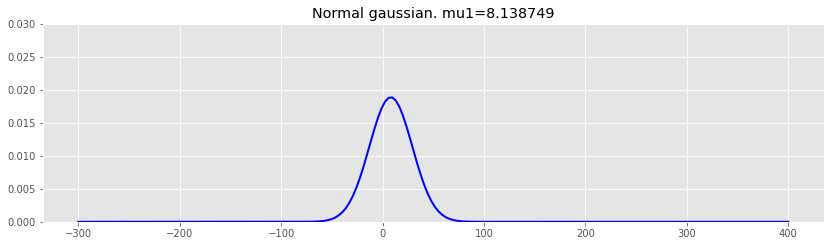

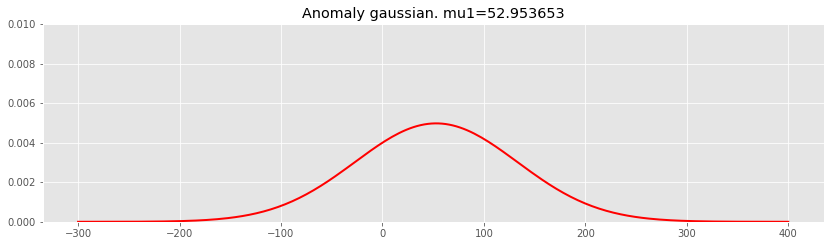

mean 8.138748838907151
anomaly mean 52.9536533389797
std 21.090066882418295
anomaly std 80.11803616807924


In [38]:
mse_value_test_normal_mean = np.mean(mse_value_test_normal)
mse_value_test_normal_std = np.std(mse_value_test_normal)

anomaly_data = np.append(mse_value_test_spike[30:40], mse_value_test_change[50:60])
anomaly_data = np.append(anomaly_data, mse_value_test_shift[80:])

mse_value_anomaly_mean = np.mean(anomaly_data)
mse_value_anomaly_std = np.std(anomaly_data)

print(mse_value_test_normal.shape)
print(anomaly_data.shape)
print('mean {}'.format(mse_value_test_normal_mean))
print('mean anomaly {}'.format(mse_value_anomaly_mean))
print('std {}'.format(mse_value_test_normal_std))
print('std anomaly {}'.format(mse_value_anomaly_std))

xmin = -300
xmax = 400

sx = 200 
xx = np.linspace(xmin, xmax, sx)

x1 = st.norm.pdf(xx, loc=mse_value_test_normal_mean, scale=mse_value_test_normal_std)

xx_anomaly = np.linspace(xmin, xmax, sx)

x2 = st.norm.pdf(xx_anomaly, loc=mse_value_anomaly_mean, scale=mse_value_anomaly_std)

plt.figure(figsize=(14, 8))
plt.subplot(211)
plt.title("Normal gaussian. mu1=%f"%(mse_value_test_normal_mean))
plt.ylim(0, 0.03)

plt.plot(xx, x1, color='b', linewidth=2, zorder = 200)

# plt.show()
plt.figure(figsize=(14, 8))
plt.subplot(212)
plt.title("Anomaly gaussian. mu1=%f"%(mse_value_anomaly_mean))
plt.ylim(0, 0.01)

plt.plot(xx, x2, color='r', linewidth=2, zorder = 200)

plt.show()

print('mean {}'.format(mse_value_test_normal_mean))
print('anomaly mean {}'.format(mse_value_anomaly_mean))
print('std {}'.format(mse_value_test_normal_std))
print('anomaly std {}'.format(mse_value_anomaly_std))

# 正常な分布の平均を変化させた場合

下記を動作させると'ROC_curve_time_series.gif'が作成されるのでgifを確認すると動画により正常なデータの分布が変わることによるROCの変化が分かる

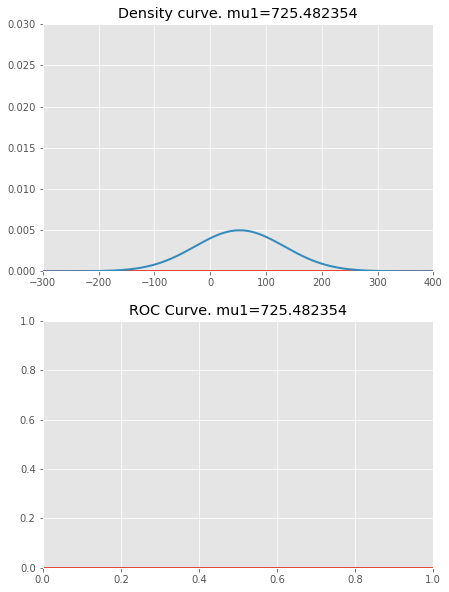

In [39]:
global mse_value_test_normal_mean_global
global mse_value_test_normal_std_global
global mse_value_anomaly_mean_global
global mse_value_anomaly_std_global

mse_value_test_normal_mean_global = mse_value_test_normal_mean
mse_value_test_normal_std_global = mse_value_test_normal_std
mse_value_anomaly_mean_global = mse_value_anomaly_mean
mse_value_anomaly_std_global = mse_value_anomaly_std

def animate(nframe):
    global num_frame
    plt.clf()
    
    xmin = -300
    xmax = 400

    # xの分割数
    sx = 200 

    # 現在位置
    pos = nframe

    # x軸生成
    xx = np.linspace(xmin, xmax, sx)

    mu1 = -300 + mse_value_test_normal_mean_global + 5 * mse_value_test_normal_mean_global * pos
    mu2 = mse_value_anomaly_mean_global
    
    sd1 = mse_value_test_normal_std_global
    sd2 = mse_value_anomaly_std_global
    
    # 分布の準備
    x1 = st.norm.pdf(xx, loc=mu1, scale=sd1)
    x2 = st.norm.pdf(xx, loc=mu2, scale=sd2)
    cx1 = st.norm.cdf(xx, loc=mu1, scale=sd1)
    cx2 = st.norm.cdf(xx, loc=mu2, scale=sd2)

    # Graph描画
    plt.subplot(211)
    plt.title("Density curve. mu1=%f"%mu1)
    plt.xlim(xmin, xmax)
    plt.ylim(0,0.03)
    ln1, = plt.plot([], [], linewidth=2, zorder = 200, animated=True)
    ln1.set_data(xx, x1)
    ln2, = plt.plot([], [], linewidth=2, zorder = 200, animated=True)
    ln2.set_data(xx, x2)
    
    plt.subplot(212)
    plt.title("ROC Curve. mu1=%f"%(mu1))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(cx2, cx1, linewidth=2)
    
    return ln1, ln2

num_frame = 26
fig = plt.figure(figsize=(7,10))
anim = ani.FuncAnimation(fig, animate, frames=num_frame, blit=True)
anim.save('ROC_curve_time_series.gif', writer='imagemagick', fps=2, dpi=64)



# ROC カーブを記述し実際の性能を確認
- 異常の部分を0、正常部分を1の配列を用意
- rocに渡すスコアの引数は正常である確信度なので異常度の場合は逆数にする必要がある

(97,)
(384,)
(384,)


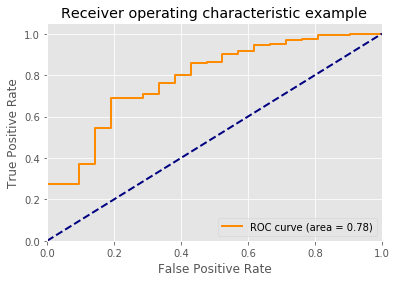

In [42]:
mse_value_test_normal = np.array(mse_value_test_normal)
mse_value_test_spike = np.array(mse_value_test_spike)
mse_value_test_change_wave = np.array(mse_value_test_change)
mse_value_test_shift = np.array(mse_value_test_shift)

# Normal
answer_normal = np.ones(X_test[window + 1:].shape)

# Spike
answer_spike = np.ones(spike_X[window + 1:].shape)
answer_spike[30:40] = 0

# Change
answer_change = np.ones(change_X[window + 1:].shape)
answer_change[50:60] = 0

# Shift
print(shift_X[window:].shape)

answer_shift = np.ones(shift_X[window + 1:].shape)
answer_shift[80] = 0

anomaly_score = np.append(mse_value_test_normal, 
                          mse_value_test_spike)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_change_wave)
anomaly_score = np.append(anomaly_score, 
                          mse_value_test_shift,
                         )

inverse_anomaly_score = 1.0 / anomaly_score

answer_array = np.append(answer_normal, answer_spike)
answer_array = np.append(answer_array, answer_change)
answer_array = np.append(answer_array, answer_shift)

print(answer_array.shape)
print(anomaly_score.shape)

fpr, tpr, _ = roc_curve(answer_array, inverse_anomaly_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()